## SIFT (Scale-Invariant Feature Transform)

### Step 1: Scale-space and DoG Pyramid

/tmp/ipykernel_80772/2829123351.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(url)


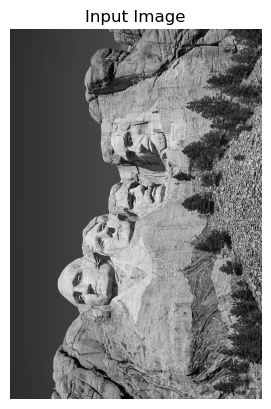

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from skimage import data
from imageio import imread

# Load grayscale image
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Mount_Rushmore_detail_view_%28100MP%29.jpg/960px-Mount_Rushmore_detail_view_%28100MP%29.jpg"
image = imread(url)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

image_r = ndimage.rotate(image, 90)

plt.imshow(image_r, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

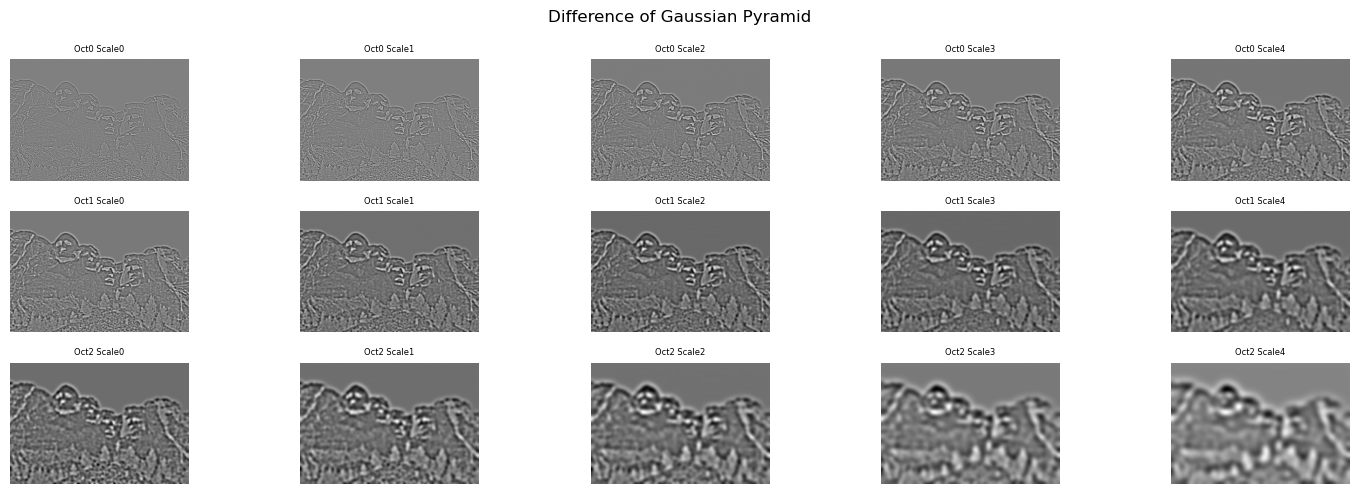

In [2]:
## Step 1a: Gaussian Pyramid
def build_gaussian_pyramid(image, num_octaves=4, num_intervals=3, sigma=1.6):
    pyramid = []
    k = 2 ** (1 / num_intervals)
    for octave in range(num_octaves):
        octave_images = []
        for i in range(num_intervals + 3):  # +3 as per SIFT paper
            curr_sigma = sigma * (k ** i)
            blurred = gaussian_filter(image, sigma=curr_sigma)
            octave_images.append(blurred)
        pyramid.append(octave_images)
        # Downsample for next octave
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    return pyramid

# Step 1b: Build the DoG pyramid from Gaussian pyramid
def build_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = []
        for i in range(1, len(octave)):
            dog = octave[i] - octave[i - 1]
            dog_octave.append(dog)
        dog_pyramid.append(dog_octave)
    return dog_pyramid

# Visualize DoG pyramid
def show_dog(dog_pyramid, num_octaves=3):
    fig, axs = plt.subplots(num_octaves, len(dog_pyramid[0]), figsize=(15, 5))
    for o in range(num_octaves):
        for i in range(len(dog_pyramid[0])):
            axs[o, i].imshow(dog_pyramid[o][i], cmap='gray')
            axs[o, i].axis('off')
            axs[o, i].set_title(f"Oct{o} Scale{i}", fontsize=6)
    plt.suptitle("Difference of Gaussian Pyramid")
    plt.tight_layout()
    plt.show()

# Build and visualize
G = build_gaussian_pyramid(image)
DoG = build_dog_pyramid(G)
show_dog(DoG)

### Step 2: Detect DoG Extrema (Keypoint Candidates)

In [3]:
def is_local_extrema(patch):
    center = patch[1, 1, 1]
    return (center == np.max(patch)) or (center == np.min(patch))

def find_scale_space_extrema(dog_pyramid, contrast_threshold=0.03):
    keypoints = []
    for o, dog_octave in enumerate(dog_pyramid):
        for i in range(1, len(dog_octave)-1):
            prev_img = dog_octave[i-1]
            curr_img = dog_octave[i]
            next_img = dog_octave[i+1]

            h, w = curr_img.shape
            for y in range(1, h-1):
                for x in range(1, w-1):
                    patch = np.stack([
                        prev_img[y-1:y+2, x-1:x+2],
                        curr_img[y-1:y+2, x-1:x+2],
                        next_img[y-1:y+2, x-1:x+2]
                    ])
                    if is_local_extrema(patch):
                        if abs(curr_img[y, x]) > contrast_threshold:
                            keypoints.append((o, i, y, x))
    return keypoints

# Detect keypoints
keypoints = find_scale_space_extrema(DoG)
print(f"Total candidate keypoints detected: {len(keypoints)}")

Total candidate keypoints detected: 650


### Step 3: Orientation Assignment (for visualization)

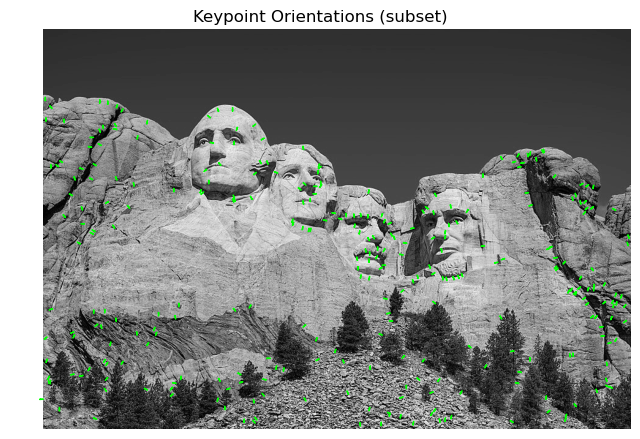

In [4]:
def compute_orientation(image, y, x, radius=8, sigma=1.5):
    patch = image[max(0, y-radius):y+radius+1, max(0, x-radius):x+radius+1]
    dy = ndimage.sobel(patch, axis=0)
    dx = ndimage.sobel(patch, axis=1)
    mag = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx) * 180 / np.pi % 360
    hist, _ = np.histogram(angle, bins=36, range=(0, 360), weights=mag)
    return hist

def visualize_orientations(image, keypoints, gaussian_pyramid):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    for (o, i, y, x) in keypoints[:300]:  # only first 300 for visualization
        g = gaussian_pyramid[o][i]
        hist = compute_orientation(g, y, x)
        dominant_angle = np.argmax(hist) * 10
        dx = np.cos(np.deg2rad(dominant_angle)) * 5
        dy = np.sin(np.deg2rad(dominant_angle)) * 5
        plt.arrow(x, y, dx, dy, color='lime', head_width=1)
    plt.title("Keypoint Orientations (subset)")
    plt.axis('off')
    plt.show()

visualize_orientations(image, keypoints, G)

Find central keypoints for comparison

3


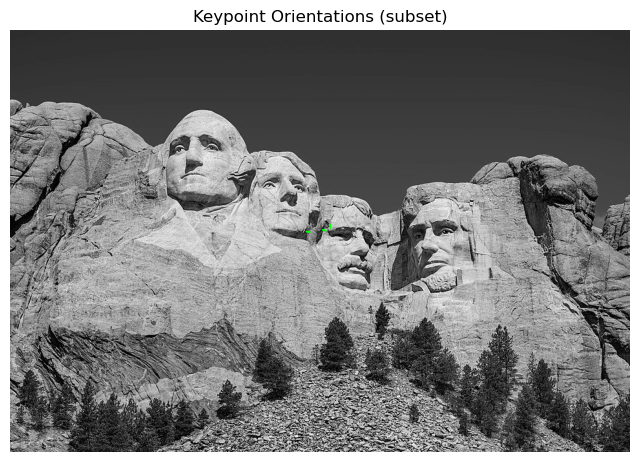

In [5]:
h, w = image.shape
central = []
for k in keypoints:
    if abs(k[2] - h/2) <= 25 and abs(k[3] - w/2) <= 25: 
        central.append(k)
print(len(central))
visualize_orientations(image, central, G)

Select same few central keypoints

In [6]:
G_r = build_gaussian_pyramid(image_r)
DoG_r = build_dog_pyramid(G_r)
keypoints_r = find_scale_space_extrema(DoG_r)

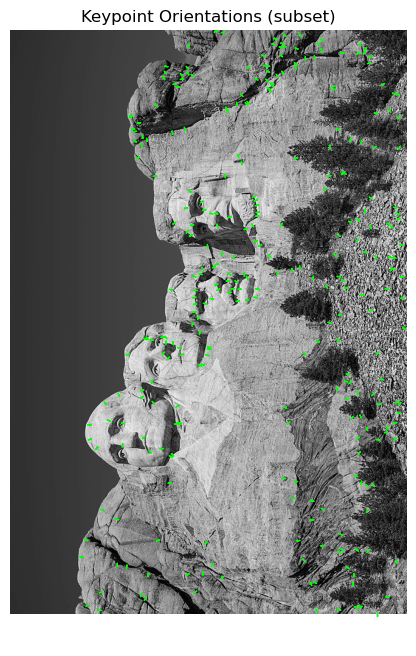

In [7]:
visualize_orientations(image_r, keypoints_r, G_r)

3


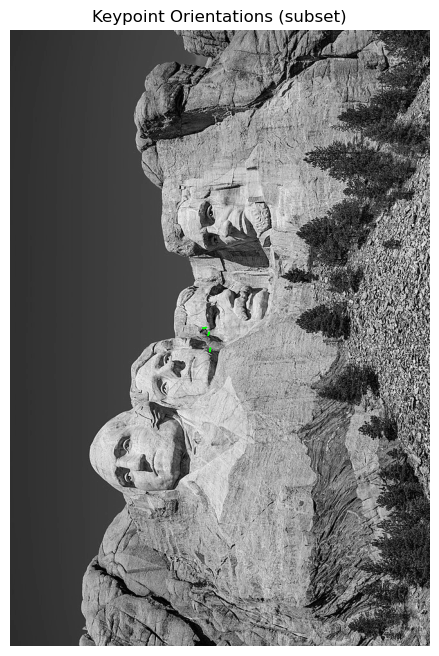

In [8]:
h, w = image_r.shape
central_r = []
for k in keypoints_r:
    if abs(k[2] - h/2-8) <= 25 and abs(k[3] - w/2) <= 25: 
        central_r.append(k)
print(len(central_r))
visualize_orientations(image_r, central_r, G_r)

Dominant orientation for normal image keypoints

In [9]:
for (o, i, y, x) in central:
    g = DoG[o][i]
    hist = compute_orientation(g, y, x)
    dominant_angle = np.argmax(hist) * 10
    print(dominant_angle)
central

100
200
40


[(0, 1, 306, 496), (0, 1, 308, 483), (0, 2, 311, 458)]

Dominant orientation for rotated image keypoints

In [10]:
for (o, i, y, x) in central_r:  # only first 300 for visualization
    g = DoG_r[o][i]
    hist = compute_orientation(g, y, x)
    dominant_angle = np.argmax(hist) * 10
    print(dominant_angle)
central_r

10
110
310


[(0, 1, 463, 306), (0, 1, 476, 308), (0, 2, 501, 311)]

### Step 4: SIFT Keypoint Matching (with OpenCV for reference)

/tmp/ipykernel_80772/311394669.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imread(url1)
/tmp/ipykernel_80772/311394669.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imread(url2)


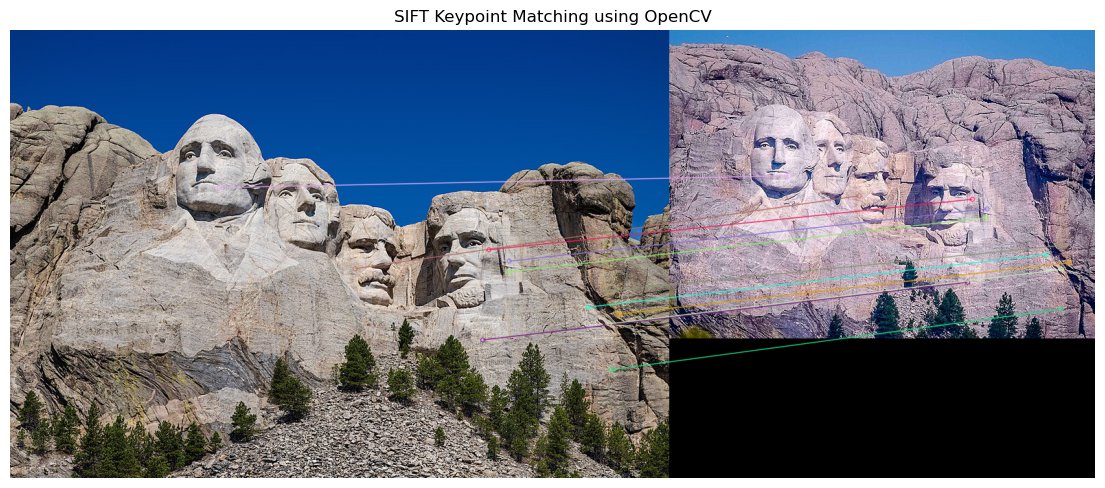

In [11]:
url1 = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Mount_Rushmore_detail_view_%28100MP%29.jpg/960px-Mount_Rushmore_detail_view_%28100MP%29.jpg"
url2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Mount_Rushmore_distant_view.jpg/620px-Mount_Rushmore_distant_view.jpg"

img1 = imread(url1)
img2 = imread(url2)


img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute((img1_gray * 255).astype(np.uint8), None)
kp2, des2 = sift.detectAndCompute((img2_gray * 255).astype(np.uint8), None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        good.append([m])

matched_img = cv2.drawMatchesKnn((img1).astype(np.uint8), kp1,
                                  (img2).astype(np.uint8), kp2,
                                  good, None, flags=2)

plt.figure(figsize=(14, 6))
plt.imshow(matched_img)
plt.axis('off')
plt.title("SIFT Keypoint Matching using OpenCV")
plt.show()
